# Задача # 
Разработать модель предсказания в каждом регионе объема продаж в штуках любого, выбранного вами, вида банки напитка Coca Cola.  Модель должна предсказывать объем продаж на каждый час следующих суток (от последней даты транзакции в датасете).
 
Описание полей в датасете: 

Фича             | Значение  
---------------- | -------------
***item_id***    | Id транзакции  
***receipt_id*** | Id чека  
***device_id***  | Id кассового аппарата  
***local_date*** | Дата и время покупки  
***barcode***    | Штрихкод  
***price***      | Цена покупки, рубли  
***quantity***   | Количество купленного товара, шт.  
***region***     | Регион  


In [115]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from typing import TypeVar
from pylab import rcParams
from itertools import product
import warnings

warnings.filterwarnings('ignore')
PandasDataFrame = TypeVar('pandas.core.frame.DataFrame')
PandasSeries = TypeVar('pandas.core.series.Series')
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_theme(style="darkgrid")

#Функция для обращения отрицательных прогнозов в 0
def positiv(x: int) -> int:
    if x < 0:
        return 0
    else:
        return x


#Функция для обособления данных об одном регионе в отдельный фрейм и объединения всех покупок в данном регионе по часам
def get_region_data(data: PandasDataFrame, region: str) -> PandasDataFrame:
    data = data[data['region'] == region]
    data = data.drop(['region'], axis=1)
    data = data.resample('1H').sum()
    
    g = sns.lineplot(data = data);
    
    return data


#Функция для проверки ряда на стационарность критерием Дики-Фуллера
def check_stationarity_series(data: PandasDataFrame)-> bool:
    test = sm.tsa.adfuller(data)
    
    if test[0]> test[4]['5%']: 
        print('Ряд не стационарен')
        return False
    else:
        print('Ряд стационарен')
        return True


#Функция которая фитит модель и отрисовывает предсказания, фит, и существующий временной ряд, также возвращает прогноз    
def fit_and_show_results(model, period: int) -> PandasSeries:
    model_fit = model.fit()
    
    fc = model_fit.forecast(period, alpha=0.05)
    fc = fc.apply(round)
    fc = fc.apply(positiv)
    
    p = sns.lineplot(data=model_fit.predict(),color='g', label='Fitted quantity')
    p = sns.lineplot(data=fc, color='r', label='Predicted quantity')
    p = sns.lineplot(data=df_reg, color='b')
    p.set(xlabel="Date", ylabel='Quantiti');
    
    return fc


В ходе рассмотрения задачи были попытки решить при помощи экстраполяции полиномами и рядами фурье, но данные подходы не показали достойный результат.  
Рассмотрим задачу как ***прогнозирование временного ряда.*** В ходе выполнения задачи стало ясно, что недостатком такого подхода будет отсутствие "хороших" данных по воскресеньям, поэтому примем сезонность равной не 7 дням, а 24 часам.   


In [116]:
df = pd.read_csv(r'..\data\dataset.csv', index_col=['local_date'], parse_dates=['local_date'])

#Уберём колонку с целочисленными индксами и выберем код товара
df = df.drop(['Unnamed: 0'], axis=1)
df = df[df['barcode'] == '2000000000008']
df = df.drop(['barcode'],
               axis = 1)

#sns.heatmap(df.corr(), annot = True, fmt='.1g')

df


,item_id,receipt_id,device_id,price,quantity,region
local_date,,,,,,
2021-02-02 00:01:43,11660932086,7364786864,352399472211233,150.0,1.0,Москва
2021-02-01 02:08:47,11647057301,7356681152,352405133338198,4.0,4.0,Ямало-Ненецкий автономный округ
2021-02-01 00:19:36,11647062239,7356684473,352402818554872,26.0,1.0,Москва
2021-02-06 09:29:52,11724229017,7400564811,352405190581318,53.0,2.0,Ханты-Мансийский автономный округ
2021-02-02 14:17:36,11669341030,7369581476,352402818554872,26.0,3.0,Москва
...,...,...,...,...,...,...
2021-02-02 00:14:20,11660832796,7364723884,352406548440871,80.0,1.0,Оренбургская область
2021-02-02 02:41:11,11660864416,7364742538,352401457619797,119.0,1.0,Алтайский край
2021-02-01 22:58:32,11660885556,7364755567,352405604088706,5.0,1.0,Воронежская область


In [117]:
print(len(df['item_id'].value_counts()), 
      len(df['receipt_id'].value_counts()))

df = df.drop(['receipt_id',
              'item_id'],
               axis = 1)


8347 8284


Видим, что количество уникальных значений у данных признаков сопоставимо с количеством семплов, значит эти признаки вряд ли информативны


In [118]:
#Удалим выбросы в данных по значениям количества и цены
df = df[df['price'] <= df['price'].quantile(0.99)]
df = df[df['quantity'] <= df['quantity'].quantile(0.99)]

#обработаем "странные" значения количества
df['quantity'] = df['quantity'].apply(round)
df = df[df['quantity'] > 0]
df = df.rename(columns = {'quantity': 'Real quantity'})

#Проиндексируем значения по времени
df = df.sort_index()


Так как мы будем рассматривать задачу как анализ временного ряда, и мы уже достали всю необходимую информацию из данных, которые не будем использовать, то можем их удалить. Оставим даты, количество и регионы.

In [120]:
#Удаляем "ненужные" признаки
df = df.drop(['device_id',
              'price'],
               axis = 1)

['Оренбургская область', 'Республика Башкортостан', 'Кировская область', 'Москва', 'Тюменская область', 'Ханты-Мансийский автономный округ', 'Московская область', 'Воронежская область', 'Ростовская область', 'Краснодарский край', 'Алтайский край', 'Иркутская область', 'Приморский край', 'Красноярский край', 'Самарская область', 'Нижегородская область', 'Республика Татарстан', 'Ямало-Ненецкий автономный округ', 'Республика Марий Эл', 'Ставропольский край', 'Липецкая область', 'Калининградская область', 'Республика Коми', 'Челябинская область', 'Ярославская область', 'Новосибирская область', 'Республика Тыва', 'Костромская область', 'Белгородская область', 'Рязанская область', 'Свердловская область', 'Мурманская область', 'Республика Крым', 'Орловская область', 'Санкт-Петербург', 'Вологодская область', 'Саратовская область', 'Кемеровская область', 'Ленинградская область', 'Курганская область', 'Республика Хакасия', 'Томская область', 'Астраханская область', 'Новгородская область', 'Пензе

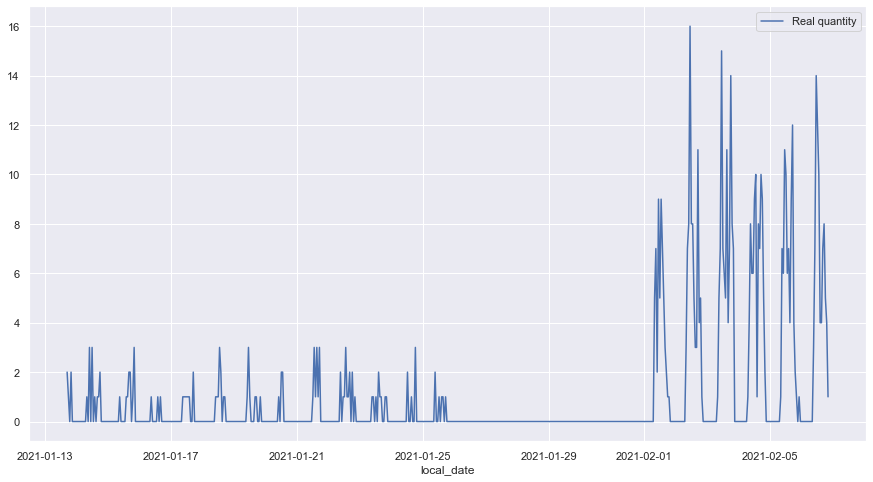

In [121]:
#Получим список регионов с продажами выбранного товара (список отсортирован по количеству продаж)
regions = list(df['region'].value_counts().index)
print(regions)

#индекс для региона принимает значения от 0 до 63
region_index = 1

#Теперь рссмотрим данные в различных регионах (меняя region_index)
df_reg = get_region_data(df, regions[region_index])

Так как в некоторых регионах (например в Республике Башкортостан) **количество измерений за январь много меньше количества измерений за февраль**, то эти данные лучше удалить, так как модель будет опираться и на эти измерения

Так как необходимо предсказать покупки на ***следующие сутки***, то наибольшую ценность имеют ***последние данные в датасете***. Рассмотрим последнюю неделю данную в датасете. К сожалению, у нас нет наблюдений за воскресенье февраля, а в последнее январское воскресенье намного меньше измерений и их нельзя объеднять с февральскими данными, иначе мы получим искажённые предсказания.  Итак, рассмотрим февральские наблюдения. 

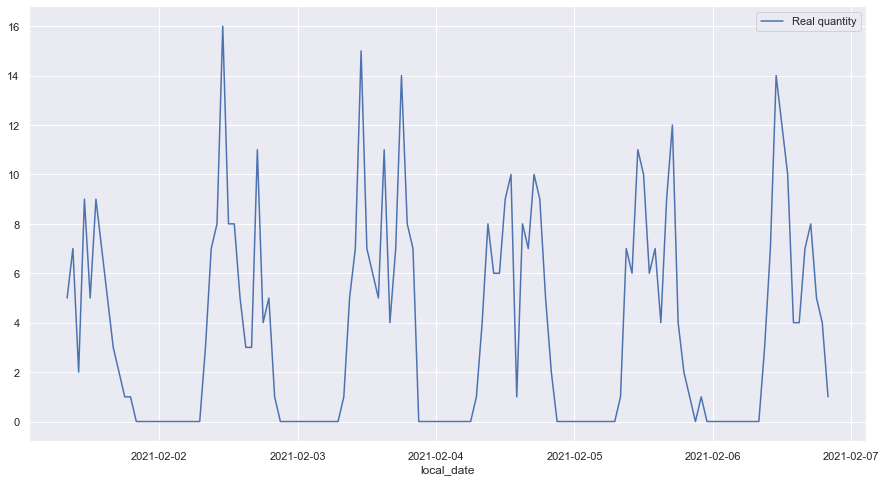

In [122]:
#Оставляем только февральские наблюдения
df = df[(pd.DatetimeIndex(df.index).year == 2021) &
        (pd.DatetimeIndex(df.index).month == 2)]

#Получаем данные по выбранному региону
df_reg = get_region_data(df, regions[region_index])


Ряд стационарен


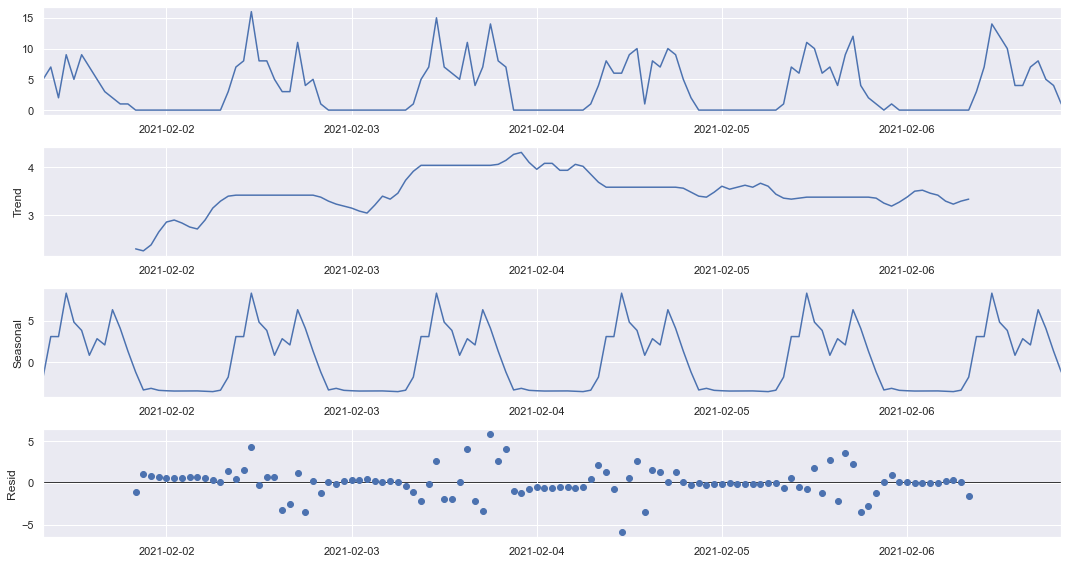

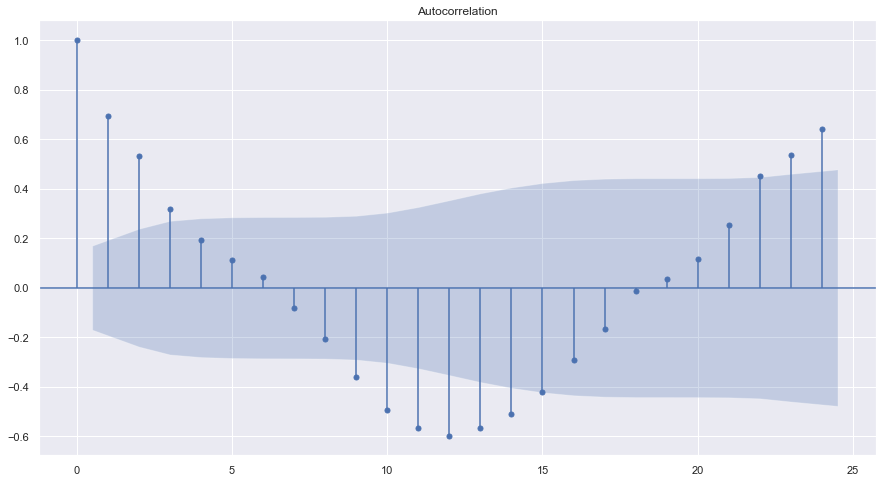

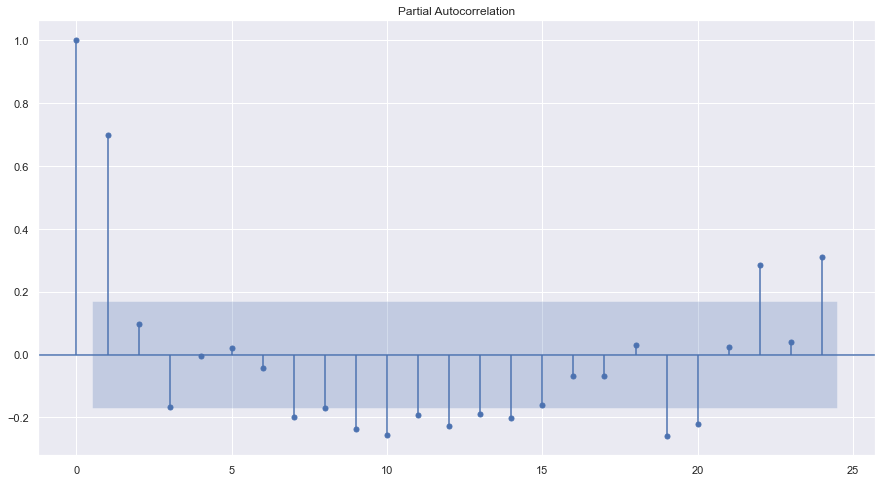

In [123]:
check_stationarity_series(df_reg)

decomposition = sm.tsa.seasonal_decompose(df_reg, model='additive')
fig = decomposition.plot()
sm.graphics.tsa.plot_acf(df_reg, lags=24)
sm.graphics.tsa.plot_pacf(df_reg, lags=24);


ARIMA(2, 1, 2) - AIC:651.7273581592535


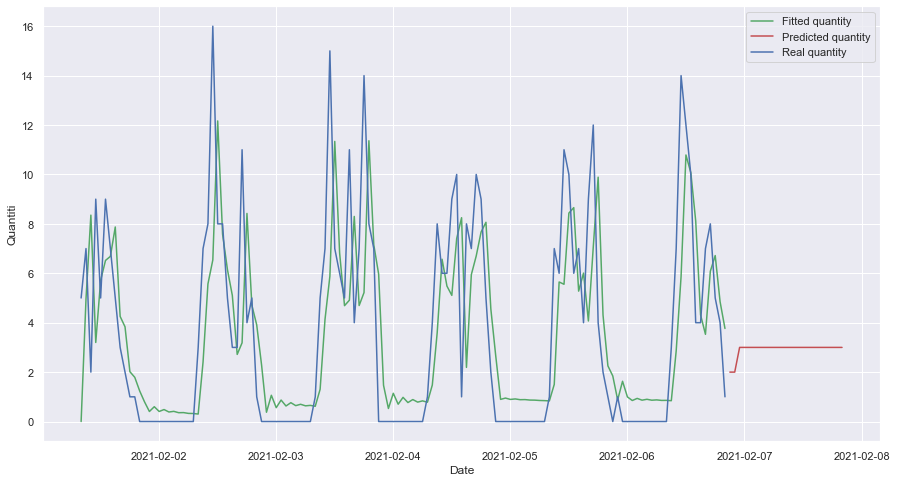

In [124]:
p = d = q = range(0, 3)

#По минимальному критерию Акаике построим модель arima
min_aic = 9999

for param in product(p, d, q):
    mod = ARIMA(df_reg,
                order=param,
                enforce_stationarity=False,
                enforce_invertibility=False)
    
    results = mod.fit()
    
    if results.aic < min_aic:
        min_aic = results.aic
        param_for_min_aic = param
        
print('ARIMA{} - AIC:{}'.format(param_for_min_aic, min_aic))        

model_ARIMA = ARIMA(df_reg, 
                    order=param_for_min_aic, 
                    enforce_stationarity=False,
                    enforce_invertibility=False) 

res_ARIMA = fit_and_show_results(model_ARIMA, 24)


ARIMA не видит сезонности, поэтому воспользуемся её модификацией SARIMA, данная модель должна учитывать сезонность

SARIMA(0, 1, 1)x(1, 1, 1, 24) - AIC:389.83077108970764


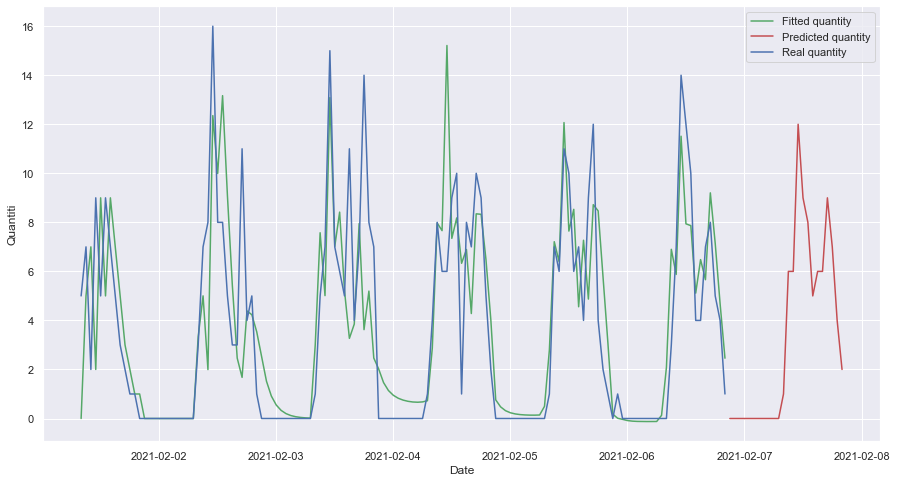

In [125]:
p = d = q = range(0, 2)
pdq = list(product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(product(p, d, q))]

#По минимальному критерию Акаике построим модель Sarima
min_aic = 9999

for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(df_reg,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        results = mod.fit()
        if results.aic < min_aic:
            min_aic = results.aic
            param_for_min_aic = param
            param_seasonal_for_min_aic = param_seasonal,results
            
print('SARIMA{}x{} - AIC:{}'.format(param_for_min_aic,
                                    param_seasonal_for_min_aic[0], 
                                    min_aic))
 
model_SARIMA = sm.tsa.statespace.SARIMAX(df_reg,
                                         order=param_for_min_aic,
                                         seasonal_order=param_seasonal_for_min_aic[0],
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)

res_SARIMA = fit_and_show_results(model_SARIMA, 24)


In [126]:
print(regions[region_index])
res_SARIMA


Республика Башкортостан


2021-02-06 21:00:00     0
2021-02-06 22:00:00     0
2021-02-06 23:00:00     0
2021-02-07 00:00:00     0
2021-02-07 01:00:00     0
2021-02-07 02:00:00     0
2021-02-07 03:00:00     0
2021-02-07 04:00:00     0
2021-02-07 05:00:00     0
2021-02-07 06:00:00     0
2021-02-07 07:00:00     0
2021-02-07 08:00:00     1
2021-02-07 09:00:00     6
2021-02-07 10:00:00     6
2021-02-07 11:00:00    12
2021-02-07 12:00:00     9
2021-02-07 13:00:00     8
2021-02-07 14:00:00     5
2021-02-07 15:00:00     6
2021-02-07 16:00:00     6
2021-02-07 17:00:00     9
2021-02-07 18:00:00     7
2021-02-07 19:00:00     4
2021-02-07 20:00:00     2
Freq: H, Name: predicted_mean, dtype: int64

# Вывод #

Была построена модель для предсказания количества продаж определённого товара на 24 часа после последней записи по каждому региону. Хочется отметьтить, что данные носят сезонный характер, а мы не имеем "хороших" данных за один из дней недели. Этот нюанс может плохо сказаться на предективной способности модели, особенно, если учесть, что нет данных за воскресенье (в этот день спрос может носить особый характер). Выходом из данной ситуации может быть дополнительный подробный сбор данных. Лучше всего, если это будет не только воскресенье, а несколько недель (будет ясно, наблюдается ли в данных тренд). Тогда будет возможность построить более корректную модель.